In [456]:
import matplotlib.pyplot as plt  
# iscrtavanje slika i plotova unutar samog browsera
%matplotlib inline 

import matplotlib.pylab as pylab
# prikaz vecih slika 
pylab.rcParams['figure.figsize'] = 12,10


import numpy as np
import cv2 # OpenCV biblioteka
import math

In [457]:
def detectLines(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize = 3)

    minLineLength = 200
    maxLineGap = 13
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, np.array([]), minLineLength, maxLineGap)

    return lines, edges

def lengthOfLine(x1, x2, y1, y2):
    
    length = math.sqrt(math.pow((x1 - x2), 2) + math.pow((y1 - y2), 2))
    return length

def getLeftAndRightPoint(x1, x2, y1, y2):
    
    rightPoint = []
    leftPoint = []
    
    if x1 - x2 < 0:
        leftPoint.append(x1)
        rightPoint.append(x2)
    else:
        leftPoint.append(x2)
        rightPoint.append(x1)
    
    if y1 - y2 < 0:
        leftPoint.append(y2)
        rightPoint.append(y1)
    else:
        leftPoint.append(y1)
        rightPoint.append(y2)
        
    return rightPoint, leftPoint 

def isRightLine(x1, x2, y1, y2, newLines):
    
    rightPoint, leftPoint = getLeftAndRightPoint(x1, x2, y1, y2)
    
    for newLine in newLines:
        for a1,b1,a2,b2 in newLine: 
            newRightPoint, newLeftPoint = getLeftAndRightPoint(a1, a2, b1, b2)
            
            if lengthOfLine(rightPoint[0], newRightPoint[0], rightPoint[1], newRightPoint[1]) > 50:
                return True
    return False
            
        
def getRightLines(lines):
    
    newLines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if len(newLines) == 0:
                newLines.append(line)
            else:
                if isRightLine(x1, x2, y1, y2, newLines) is True:
                    newLines.append(line)
                    
                    if len(newLines) == 2:
                        return newLines
    return -1


In [458]:
cap = cv2.VideoCapture('videos/video-8.avi')

Broj detektovanih linija: 2


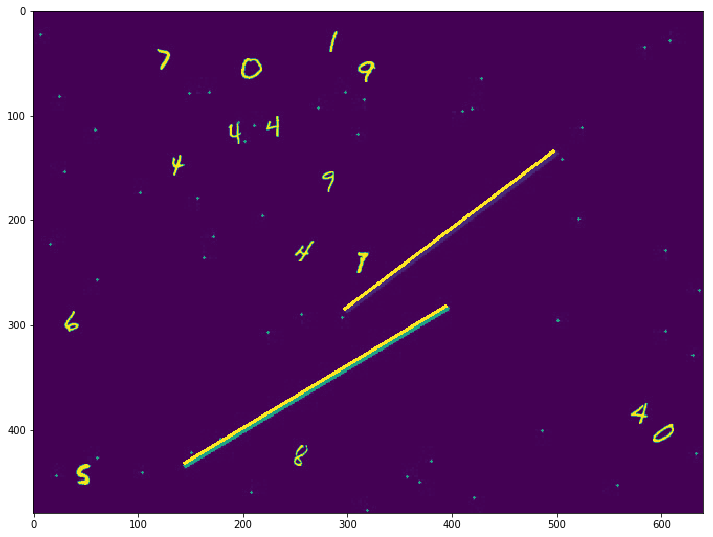

In [459]:
while(cap.isOpened()):
    ret, frame = cap.read()


    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    lines, edges = detectLines(frame)
    
    lines = getRightLines(lines)
    print('Broj detektovanih linija: ' + str(len(lines)))
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(gray, (x1, y1), (x2, y2), (255, 255, 255), 2)
            #print('Duzina linije: ' + str(lengthOfLine(x1,x2,y1,y2)))

    plt.imshow(gray)
    break;